#cargamos las librerias

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from  tensorflow.keras import models, optimizers, regularizers

### visualizamos nuestro arreglos de imagenes para verificar de que se trata


Forma del arreglo de todas las imágenes: (1008, 150, 150, 3)


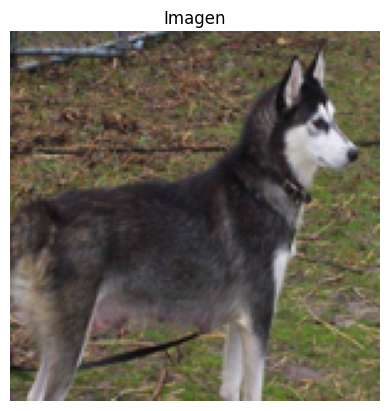

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Rutas de las carpetas que contienen las imágenes
ruta_carpeta_dog = '/content/train/dog'
ruta_carpeta_cat = '/content/train/cat'

# Función para cargar imágenes de una carpeta en un arreglo
def cargar_imagenes(ruta_carpeta):
    imagenes = []
    extensiones_validas = ['.jpg', '.jpeg', '.png']  # Agrega las extensiones válidas
    for nombre_archivo in os.listdir(ruta_carpeta):
        if any(nombre_archivo.lower().endswith(ext) for ext in extensiones_validas):
            ruta_completa = os.path.join(ruta_carpeta, nombre_archivo)
            imagen = Image.open(ruta_completa)
            imagen = imagen.resize((150, 150))  # Redimension a 150x150 píxeles
            arreglo_imagen = np.array(imagen) / 255.0  # Normaliza los valores de píxeles
            imagenes.append(arreglo_imagen)
    return imagenes

# Cargar imágenes de las carpetas
imagenes_dog = cargar_imagenes(ruta_carpeta_dog)
imagenes_cat = cargar_imagenes(ruta_carpeta_cat)

# Convertir listas de imágenes en arreglos NumPy
imagenes_dog_array = np.array(imagenes_dog)
imagenes_cat_array = np.array(imagenes_cat)

# Unir los arreglos de perros y gatos en un solo arreglo
todas_imagenes_array = np.concatenate((imagenes_dog_array, imagenes_cat_array), axis=0)

# Verificar la forma del arreglo resultante
print("Forma del arreglo de todas las imágenes:", todas_imagenes_array.shape)

# Visualizar una imagen
plt.imshow(todas_imagenes_array[0])
plt.title("Imagen")
plt.axis('off')
plt.show()

creamos un generador de imagenes con el fin de gererar la data augmentation , es decir , generar nuevas imagenes apartir de las que ya tenemos

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,# escalamos la data
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

ahora le decimos al generador de donde sacara las imagenes y en que dimensiones las colocara

In [4]:
train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(150, 150),#especificamos las dimesiones en las que queremos la imagen
    batch_size=32,
    class_mode='binary',
    classes=['cat', 'dog']#especificamo las clases que queremos
)

Found 1008 images belonging to 2 classes.


aqui podemos ver que ya detecto 2 clases , con el codigo de abajo vemos cuales clases esta detectando


In [5]:
print("Clases detectadas:", train_generator.class_indices)

Clases detectadas: {'cat': 0, 'dog': 1}


hacemos otro generador pero para las imagenes de validacion , a este solo le diremos que escale las imagenes para que queden entre 1 y 0  sus valores


In [6]:
validation_data = ImageDataGenerator(rescale=1./255)

In [8]:
validation_generator = validation_data.flow_from_directory('/content/validation',#ruta en donde estan las imagenes
                                 target_size=(150,150),# tamaño en el que queremos las imagenes
                                 batch_size=32,
                                 class_mode='binary',
                                 classes=['cat', 'dog']) # especificamos la clases que queremos

Found 1006 images belonging to 2 classes.


# armamos nuestros modelos

modelo 1:simple


In [ ]:
modelo1 = models.Sequential()

modelo1.add(Conv2D(32, (3,3), activation= 'relu', input_shape=(150,150,3)))
modelo1.add(MaxPooling2D((2,2)))

modelo1.add(Conv2D(64, (3,3), activation = 'relu'))
modelo1.add(MaxPooling2D((2,2)))

modelo1.add(Conv2D(128, (3,3), activation = 'relu'))
modelo1.add(MaxPooling2D((2,2)))


modelo1.add(Flatten())
modelo1.add(Dense(512, activation='relu'))
modelo1.add(Dense(1, activation='sigmoid'))

modelo1.summary()

definimos un checkpoint para guardar el modelo

In [10]:
checkpoint = ModelCheckpoint('modelo1_perros_gatos.hdf5',monitor='val_accuracy', verbose= 1, save_best_only=True)

compilamos nuestros modelo

In [11]:
modelo1.compile(loss='binary_crossentropy', optimizer =optimizers.Adam(),
             metrics=['accuracy'])

entrenamos nuestro modelo 1


In [12]:
historia_modelo1 = modelo1.fit(train_generator, steps_per_epoch=1000//32,
                epochs=120,
                validation_data=validation_generator,
                validation_steps=1000//32,
                callbacks=[checkpoint])

Epoch 1/120
31/31 [==============================] - ETA: 0s - loss: 0.7642 - accuracy: 0.4867
Epoch 1: val_accuracy improved from -inf to 0.50202, saving model to modelo1_perros_gatos.hdf5
31/31 [==============================] - 22s 330ms/step - loss: 0.7642 - accuracy: 0.4867 - val_loss: 0.6893 - val_accuracy: 0.5020
Epoch 2/120
31/31 [==============================] - ETA: 0s - loss: 0.6660 - accuracy: 0.5717
Epoch 2: val_accuracy improved from 0.50202 to 0.57056, saving model to modelo1_perros_gatos.hdf5
31/31 [==============================] - 10s 313ms/step - loss: 0.6660 - accuracy: 0.5717 - val_loss: 0.6608 - val_accuracy: 0.5706
Epoch 3/120
31/31 [==============================] - ETA: 0s - loss: 0.6690 - accuracy: 0.5871
Epoch 3: val_accuracy did not improve from 0.57056
31/31 [==============================] - 8s 252ms/step - loss: 0.6690 - accuracy: 0.5871 - val_loss: 0.6788 - val_accuracy: 0.5514
Epoch 4/120
31/31 [==============================] - ETA: 0s - loss: 0.6690 

graficamos para ver como es el comportamiento de el accuracy atravez de las epocas

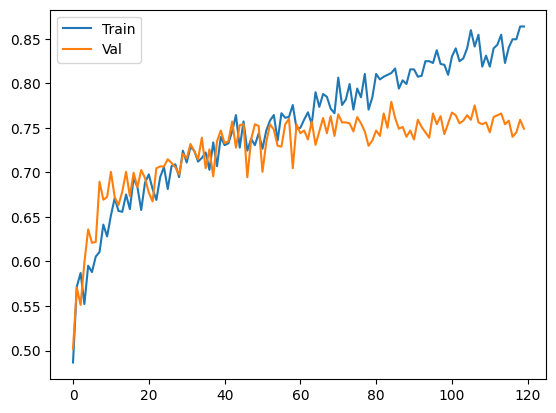

In [13]:
import matplotlib.pyplot as plt
plt.plot(historia_modelo1.history['accuracy'], label = 'Train')
plt.plot(historia_modelo1.history['val_accuracy'], label = 'Val')
plt.legend()
plt.show()

escalamos nuestros datos de test para utilizarlos

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
test_generator = test_datagen.flow_from_directory('/content/test',
                                 target_size=(150,150),
                                 batch_size=32,
                                 class_mode='binary',
                                 classes=['cat', 'dog']
                                 )

Found 936 images belonging to 2 classes.


evaluamos el modelo con nuestros datos de prueba

In [16]:
evaluacion1=modelo1.evaluate(test_generator)
evaluacion1

30/30 [==============================] - 2s 59ms/step - loss: 0.6893 - accuracy: 0.7692


[0.6892829537391663, 0.7692307829856873]

## modelo2: batch normalization


a este modelo le colocaremos 3 capas de convolucion y 2 caapas densas, estas tendran 512 y 256 neuronas , adicional tendra BatchNormalization en sus capas de convolucion

In [17]:
from keras.layers import BatchNormalization
modelo2 = models.Sequential()

modelo2.add(Conv2D(32, (3,3), padding='same', activation= 'relu', input_shape=(150,150,3)))
modelo2.add(BatchNormalization())
modelo2.add(MaxPooling2D((2,2)))

modelo2.add(Conv2D(64, (3,3), activation = 'relu'))
modelo2.add(BatchNormalization())
modelo2.add(MaxPooling2D((2,2)))

modelo2.add(Conv2D(128, (3,3), activation = 'relu'))
modelo2.add(BatchNormalization())
modelo2.add(MaxPooling2D((2,2)))


modelo2.add(Flatten())
modelo2.add(Dense(512, activation='relu'))
modelo2.add(Dense(256, activation='relu'))
modelo2.add(Dense(1, activation='sigmoid'))

modelo2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 73, 73, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 73, 73, 64)       256       
 hNormalization)                                                 
                                                      

compilamos el modelo

In [18]:
modelo2.compile(loss='binary_crossentropy', optimizer =optimizers.Adam(),
             metrics=['accuracy'])

creamos nuestro checkpoint

In [19]:
checkpoint2 = ModelCheckpoint('modelo2_perros_gatos.hdf5',monitor='val_accuracy', verbose= 1, save_best_only=True)

entrenamos nuestro segundo modelo con BatchNormalization

In [21]:
historia_modelo2 = modelo2.fit(train_generator, steps_per_epoch=1000//32,
                epochs=120,
                validation_data=validation_generator,
                validation_steps=1000//32,
                callbacks=[checkpoint2])

Epoch 1/120
31/31 [==============================] - ETA: 0s - loss: 3.6640 - accuracy: 0.5133
Epoch 1: val_accuracy improved from -inf to 0.48992, saving model to modelo2_perros_gatos.hdf5
31/31 [==============================] - 12s 370ms/step - loss: 3.6640 - accuracy: 0.5133 - val_loss: 0.8345 - val_accuracy: 0.4899
Epoch 2/120
31/31 [==============================] - ETA: 0s - loss: 1.4301 - accuracy: 0.5635
Epoch 2: val_accuracy did not improve from 0.48992
31/31 [==============================] - 10s 320ms/step - loss: 1.4301 - accuracy: 0.5635 - val_loss: 0.9946 - val_accuracy: 0.4476
Epoch 3/120
31/31 [==============================] - ETA: 0s - loss: 1.0358 - accuracy: 0.5820
Epoch 3: val_accuracy improved from 0.48992 to 0.50504, saving model to modelo2_perros_gatos.hdf5
31/31 [==============================] - 11s 348ms/step - loss: 1.0358 - accuracy: 0.5820 - val_loss: 2.5787 - val_accuracy: 0.5050
Epoch 4/120
31/31 [==============================] - ETA: 0s - loss: 0.8947

graficamos el comportamiento den entrenamiento para ver su rendimiento

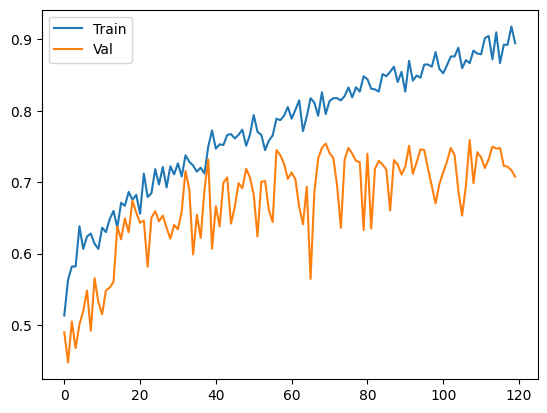

In [22]:
import matplotlib.pyplot as plt
plt.plot(historia_modelo2.history['accuracy'], label = 'Train')
plt.plot(historia_modelo2.history['val_accuracy'], label = 'Val')
plt.legend()
plt.show()

evaluamos nuestro modelo

In [23]:
evaluacion2=modelo2.evaluate(test_generator)
evaluacion2

30/30 [==============================] - 2s 56ms/step - loss: 1.2430 - accuracy: 0.7425


[1.2429990768432617, 0.742521345615387]

# modelo 3: dropout y regularizacion


para este 3er modelo tenemos 4 capas de convolucion , con regularizacion l2 y dropout en cada capa de convolucion , con dos capas densas y su dropout correspondiente

In [24]:
from keras.layers import Dropout
from keras.regularizers import l2

modelo3 = models.Sequential()

modelo3.add(Conv2D(32, (3,3), padding='same', activation= 'relu', kernel_regularizer=l2(0.01), input_shape=(150,150,3)))
modelo3.add(BatchNormalization())
modelo3.add(MaxPooling2D((2,2)))
modelo3.add(Dropout(0.25))

modelo3.add(Conv2D(64, (3,3), activation = 'relu',kernel_regularizer=l2(0.01)))
modelo3.add(BatchNormalization())
modelo3.add(MaxPooling2D((2,2)))
modelo3.add(Dropout(0.25))


modelo3.add(Conv2D(128, (3,3), activation = 'relu',kernel_regularizer=l2(0.01)))
modelo3.add(BatchNormalization())
modelo3.add(MaxPooling2D((2,2)))
modelo3.add(Dropout(0.25))

modelo3.add(Conv2D(128, (3,3), activation = 'relu',kernel_regularizer=l2(0.01)))
modelo3.add(BatchNormalization())
modelo3.add(MaxPooling2D((2,2)))
modelo3.add(Dropout(0.5))

modelo3.add(Flatten())
modelo3.add(Dense(512, activation='relu',kernel_regularizer=l2(0.01)))
modelo3.add(Dropout(0.25))
modelo3.add(Dense(1, activation='sigmoid'))

modelo3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 73, 73, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 73, 73, 64)      

In [25]:
checkpoint3 = ModelCheckpoint('modelo3_perros_gatos.hdf5',monitor='val_accuracy', verbose= 1, save_best_only=True)

In [26]:
modelo3.compile(loss='binary_crossentropy', optimizer =optimizers.Adam(),
             metrics=['accuracy'])

entrenamos nuestro modelo

In [27]:
historia_modelo3 = modelo3.fit(train_generator, steps_per_epoch=1000//32,
                epochs=120,
                validation_data=validation_generator,
                validation_steps=1000//32,
                callbacks=[checkpoint3])

Epoch 1/120
31/31 [==============================] - ETA: 0s - loss: 13.7619 - accuracy: 0.5061
Epoch 1: val_accuracy improved from -inf to 0.51714, saving model to modelo3_perros_gatos.hdf5
31/31 [==============================] - 14s 296ms/step - loss: 13.7619 - accuracy: 0.5061 - val_loss: 11.0697 - val_accuracy: 0.5171
Epoch 2/120
31/31 [==============================] - ETA: 0s - loss: 10.2308 - accuracy: 0.5512
Epoch 2: val_accuracy did not improve from 0.51714
31/31 [==============================] - 9s 301ms/step - loss: 10.2308 - accuracy: 0.5512 - val_loss: 9.1765 - val_accuracy: 0.4960
Epoch 3/120
31/31 [==============================] - ETA: 0s - loss: 8.2502 - accuracy: 0.5912
Epoch 3: val_accuracy did not improve from 0.51714
31/31 [==============================] - 10s 332ms/step - loss: 8.2502 - accuracy: 0.5912 - val_loss: 7.4764 - val_accuracy: 0.5000
Epoch 4/120
31/31 [==============================] - ETA: 0s - loss: 6.7492 - accuracy: 0.6004
Epoch 4: val_accuracy d

graficamos el comportamiento del entrenamiento

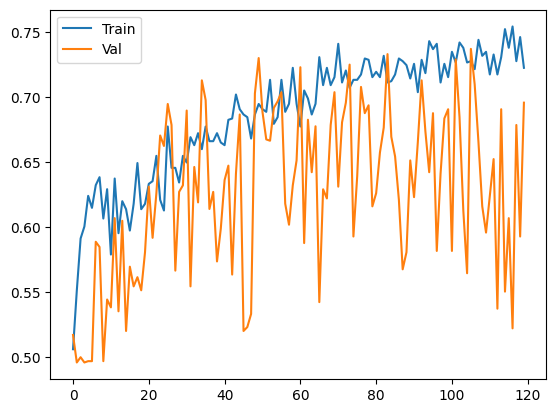

In [28]:
import matplotlib.pyplot as plt
plt.plot(historia_modelo3.history['accuracy'], label = 'Train')
plt.plot(historia_modelo3.history['val_accuracy'], label = 'Val')
plt.legend()
plt.show()

evaluamos nuestro modelo

In [29]:
evaluacion3=modelo3.evaluate(test_generator)
evaluacion3

30/30 [==============================] - 2s 55ms/step - loss: 0.8419 - accuracy: 0.6795


[0.8419177532196045, 0.6794871687889099]

# modelo 4 :

este modelo tiene 3 capas de convolucion cada una con regularizador l2 BatchNormalization y su respectivo dropout, ademas 2 capas densas con su dropout

In [30]:
from keras.regularizers import l2
from keras.layers import Dropout
from keras.layers import BatchNormalization

modelo4 = models.Sequential()

modelo4.add(Conv2D(32, (3,3), activation= 'relu',kernel_regularizer=l2(0.01),padding='same', input_shape=(150,150,3)))
modelo4.add(BatchNormalization())
modelo4.add(MaxPooling2D((2,2)))

modelo4.add(Conv2D(64, (3,3), activation = 'relu',kernel_regularizer=l2(0.01)))
modelo4.add(BatchNormalization())
modelo4.add(MaxPooling2D((2,2)))
modelo4.add(Dropout(0.5))

modelo4.add(Conv2D(64, (3,3), activation = 'relu',kernel_regularizer=l2(0.01)))
modelo4.add(BatchNormalization())
modelo4.add(MaxPooling2D((2,2)))
modelo4.add(Dropout(0.5))



modelo4.add(Flatten())
modelo4.add(Dense(512, activation='relu'))
modelo4.add(Dropout(0.25))
modelo4.add(Dense(1, activation='sigmoid'))

modelo4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 batch_normalization_7 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 73, 73, 64)        18496     
                                                                 
 batch_normalization_8 (Batc  (None, 73, 73, 64)       256       
 hNormalization)                                                 
                                                      

In [31]:
checkpoint4 = ModelCheckpoint('modelo4_perros_gatos.hdf5',monitor='val_accuracy', verbose= 1, save_best_only=True)

In [32]:
modelo4.compile(loss='binary_crossentropy', optimizer =optimizers.Adam(),
             metrics=['accuracy'])

entrenmos nuestro modelo 4

In [33]:
historia_modelo4 = modelo4.fit(train_generator, steps_per_epoch=1000//32,
                epochs=120,
                validation_data=validation_generator,
                validation_steps=1000//32,
                callbacks=[checkpoint4])

Epoch 1/120
31/31 [==============================] - ETA: 0s - loss: 4.8908 - accuracy: 0.5400
Epoch 1: val_accuracy improved from -inf to 0.49798, saving model to modelo4_perros_gatos.hdf5
31/31 [==============================] - 13s 305ms/step - loss: 4.8908 - accuracy: 0.5400 - val_loss: 6.4800 - val_accuracy: 0.4980
Epoch 2/120
31/31 [==============================] - ETA: 0s - loss: 1.9018 - accuracy: 0.5656
Epoch 2: val_accuracy did not improve from 0.49798
31/31 [==============================] - 10s 328ms/step - loss: 1.9018 - accuracy: 0.5656 - val_loss: 7.7040 - val_accuracy: 0.4980
Epoch 3/120
31/31 [==============================] - ETA: 0s - loss: 1.6455 - accuracy: 0.6055
Epoch 3: val_accuracy did not improve from 0.49798
31/31 [==============================] - 10s 310ms/step - loss: 1.6455 - accuracy: 0.6055 - val_loss: 8.3777 - val_accuracy: 0.4960
Epoch 4/120
31/31 [==============================] - ETA: 0s - loss: 1.5575 - accuracy: 0.6086
Epoch 4: val_accuracy impro

graficamos nuestro entrenamiento

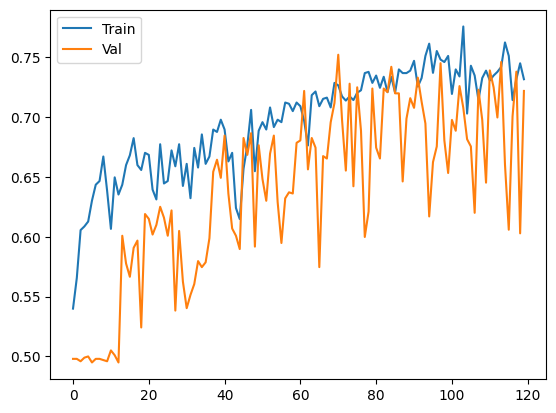

In [34]:
import matplotlib.pyplot as plt
plt.plot(historia_modelo4.history['accuracy'], label = 'Train')
plt.plot(historia_modelo4.history['val_accuracy'], label = 'Val')
plt.legend()
plt.show()

In [35]:
evaluacion4=modelo4.evaluate(test_generator)
evaluacion4

30/30 [==============================] - 2s 54ms/step - loss: 0.6722 - accuracy: 0.6987


[0.6721771955490112, 0.6987179517745972]

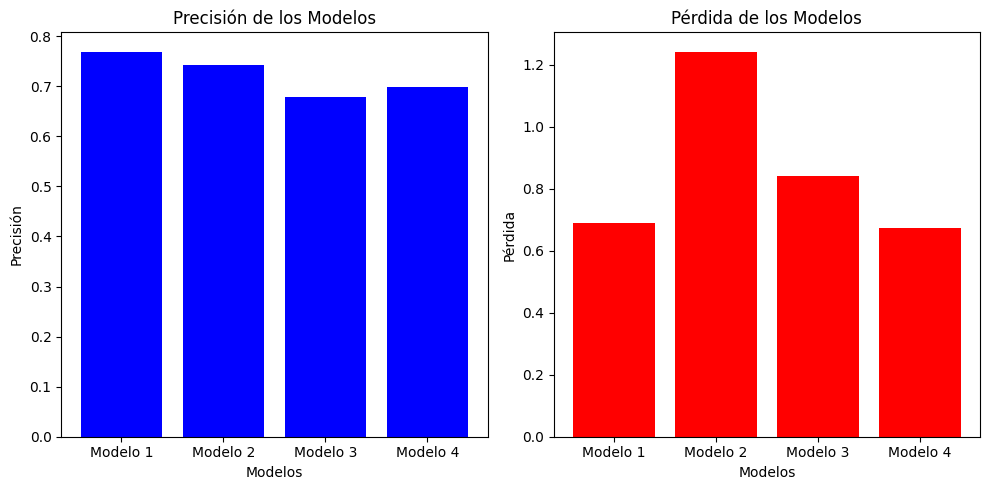

In [37]:
model_names = ['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4']
accuracies = [evaluacion1[1], evaluacion2[1], evaluacion3[1], evaluacion4[1]]
losses = evaluacion1[0], evaluacion2[0], evaluacion3[0], evaluacion4[0]

# Gráfico de precisión
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(model_names, accuracies, color='blue')
plt.title('Precisión de los Modelos')
plt.xlabel('Modelos')
plt.ylabel('Precisión')

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.bar(model_names, losses, color='red')
plt.title('Pérdida de los Modelos')
plt.xlabel('Modelos')
plt.ylabel('Pérdida')

# Mostrar los gráficos
plt.tight_layout()
plt.show()








podemos concluir que nuestro primero modelo es el mejor ya que es el que mejor se adapto a los datos de entrenamiento y validatcion obteniendo una buena precision y una buena perdida ya que el segundo tendio a sobreajustarse ya que subia el accuracy en el entrenamiento pero disminuia en la validacion y en el caso del 3ero y el 4to hubo algunas inconsistencias en la validacion  